##**M2. La ciencia de datos. Técnicas de análisis, minería y visualización - Caso Práctico Nº 1**

### **Enunciado**
Cada día es más frecuente la introducción de la ciencia de datos en el ámbito del derecho y la justicia. Un ejemplo bien conocido de ello es el sistema COMPAS (Correctional offender management profiling for alternative sanctions) que se usa en varios estados de los Estados Unidos para hacer una evaluación del riesgo de reincidencia de las personas detenidas. Una breve descripción del sistema puede verse en la página https://en.wikipedia.org/wiki/COMPAS_(software).

En este caso, proporciona un conjunto de datos en bruto con información de las evaluaciones (fichero compas-scores.csv) y la historia legal de unos 11 000 casos en los años 2013 y 2014 (se trata de uno de los ficheros originales utilizados en un análisis independiente del sistema COMPAS llevado a cabo por ProPublica, disponible en internet). Aunque el conjunto de datos contiene información adicional, para resolver las cuestiones planteadas en este caso son necesarios (aparte de algunos campos cuyo nombre es autoexplicativo) los siguientes campos:


* **“compas_screening_date”**: se refiere a la fecha en la que se realizó la evaluación
* **“decile_score”**: es un número, de 1 a 10 que indica el riesgo de reincidencia en general (a mayor riesgo, mayor número).
* **“v_decile_score”**: es un número de 1 a 10, potencialmente distinto del anterior, que indica el riesgo de reincidencia en delitos violentos. Al hacer la evaluación de un caso en COMPAS, se generan las dos puntuaciones (entre otras cosas).
* **“is_recid”**: indicación de si la persona es reincidente (en el tiempo en que se recogen datos: no hay información de si la persona es reincidente más allá de ciertas fechas, y es importante tener esto en cuenta para asegurarse de hacer comparaciones homogéneas).
* **“r_offense_date”**: fecha en la que se cometió el delito por el que se considera reincidente a la persona.
* **“is_violent_recid”**: indicación de si la persona es reincidente en un delito con violencia (las mismas consideraciones sobre fechas que para “is_recid” aplican aquí)".
* **“vr_offense_date”**: fecha en la que se cometió el delito violento que da lugar a la consideración de reincidente.

### **Se pide**

1 - Cargar los datos y realizar un análisis exploratorio y una evaluación de la calidad de los datos necesarios para el resto del caso. Específicamente, evaluar la **integridad, validez y actualidad** de los datos y proponer estrategias de mitigación de los posibles problemas encontrados.

2 - ¿Son los campos **“is_recid”** e **“is_violent_recid”** en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS? Si no es así, definir y calcular una feature que sí lo sea.

3 - El umbral para establecer **medidas preventivas de la reincidencia es de 7 en adelante**. Dado este umbral, generar una tabla de contingencia, explicando qué caso se considera como “positivo” (y, por lo tanto, cuáles son los errores de tipo I y los errores de tipo II).

4 - El sistema asigna, de media, evaluaciones de riesgo más altas a los hombres que a las mujeres, y a las personas de raza afroamericana que a las de raza caucásica. Sin embargo, también las tasas de reincidencia son más altas para esos colectivos, aunque no está claro que la asignación de riesgo sea “justa” o no. Mostrar estas diferencias mediante representaciones gráficas y utilizarlas para analizar si la asignación de evaluaciones es justa o no.
  
5 - ¿Para qué tipo de riesgos, el de delitos generales o el de delitos violentos, tiene el sistema más capacidad predictiva?


***NOTA: Este caso práctico debe realizarse íntegramente en Python.***






# **Resolución**

##1 - Cargar los datos y realizar un análisis exploratorio y una evaluación de la calidad de los datos necesarios para el resto del caso. Específicamente, evaluar la **integridad, validez y actualidad** de los datos y proponer estrategias de mitigación de los posibles problemas encontrados.

####Importación de librerias, carga de datos y primeras observaciones

In [194]:
# Importamos librerias
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
%matplotlib inline
import warnings

# Ignorar las advertencias
warnings.filterwarnings('ignore')

In [195]:
# Carga de datos
df_raw = pd.read_csv("/content/compas-scores.csv")

In [196]:
# Estructura del dataframe
# Filas = 11757
# Columnas = 47
df_raw.shape

(11757, 47)

In [197]:
# Observación de los primeros 5 registros
df_raw.head(5)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


In [198]:
# Información sobre los datos:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11757 non-null  int64  
 1   name                     11757 non-null  object 
 2   first                    11757 non-null  object 
 3   last                     11757 non-null  object 
 4   compas_screening_date    11757 non-null  object 
 5   sex                      11757 non-null  object 
 6   dob                      11757 non-null  object 
 7   age                      11757 non-null  int64  
 8   age_cat                  11757 non-null  object 
 9   race                     11757 non-null  object 
 10  juv_fel_count            11757 non-null  int64  
 11  decile_score             11757 non-null  int64  
 12  juv_misd_count           11757 non-null  int64  
 13  juv_other_count          11757 non-null  int64  
 14  priors_count          

In [199]:
# Observación de valores duplicados
df_raw.duplicated().sum()

0

In [200]:
# Observación de valores nulos
df_raw.isnull().sum()

id                             0
name                           0
first                          0
last                           0
compas_screening_date          0
sex                            0
dob                            0
age                            0
age_cat                        0
race                           0
juv_fel_count                  0
decile_score                   0
juv_misd_count                 0
juv_other_count                0
priors_count                   0
days_b_screening_arrest     1180
c_jail_in                   1180
c_jail_out                  1180
c_case_number                742
c_offense_date              2600
c_arrest_date               9899
c_days_from_compas           742
c_charge_degree                0
c_charge_desc                749
is_recid                       0
num_r_cases                11757
r_case_number               8054
r_charge_degree                0
r_days_from_arrest          9297
r_offense_date              8054
r_charge_d

**Primeras observaciones:**
* El dataframe original cuenta con 11757 registros o filas.
* El dataframe original cuenta co 47 columnas.
* Existen columnas tipo numericas (int, float)
* Columnas con número pequeño de valores (ej: sex): Interpretadas como object.
* Columnas con fechas: Interpretadas como object.
* Se pueden observar dos campos sin valores: **num_r_cases**, **num_vr_cases**.
* A priori, no se observan registros duplicados
* Se observan una gran cantidad de valores nulos en algunos campos.

####Aplicación de filtros para eliminar registros, siguiendo lineamientos de **Propublica**

Siguiendo los lineamientos del análisis realizado por [Probublica](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm), se detalla un número de casos por los cuales se eliminan registros por falta de datos:

"There are a number of reasons remove rows because of missing data:

1. If the charge date of a defendants Compas scored crime **was not within 30 days from when the person was arrested**, we assume that because of data quality reasons, that **we do not have the right offense**.
2. We coded the recidivist flag **is_recid** to be **-1 if we could not find a
compas case at all.**
3. In a similar vein, **ordinary traffic offenses** -- those with a **c_charge_degree of 'O'** -- will **not result in Jail time are removed**.
We did not count as recidivists people who were arrested **for failing to appear at their court hearings, or people who were later charged with a crime that occurred prior to their COMPAS screening**.
4. We filtered the underlying data from Broward county to include **only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.**"

In [237]:
# Pasamos las columnas de dates a datetime

date_cols = ["dob","compas_screening_date","dob","c_jail_in","c_jail_out","c_offense_date","v_screening_date","screening_date",
"vr_offense_date","r_jail_out","r_jail_in","r_offense_date","c_arrest_date"]

def cols_to_datetime (df, date_cols):
  for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')

cols_to_datetime (df_raw, date_cols)


In [238]:
# Corroboramos el correcto cambio de dtypes de las columnas
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       11757 non-null  int64         
 1   name                     11757 non-null  object        
 2   first                    11757 non-null  object        
 3   last                     11757 non-null  object        
 4   compas_screening_date    11757 non-null  datetime64[ns]
 5   sex                      11757 non-null  object        
 6   dob                      11757 non-null  datetime64[ns]
 7   age                      11757 non-null  int64         
 8   age_cat                  11757 non-null  object        
 9   race                     11757 non-null  object        
 10  juv_fel_count            11757 non-null  int64         
 11  decile_score             11757 non-null  int64         
 12  juv_misd_count           11757 n

In [239]:
# 1. If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
df_filtered = df_raw[(df_raw['days_b_screening_arrest'] < 30) &
                     (df_raw['days_b_screening_arrest'] > -30)]
df_filtered.shape

(9377, 47)

In [240]:
# 2. We coded the recidivist flag is_recid to be -1 if we could not find a compas case at all.

# Definimos las columnas a observar
cols = ['is_recid', 'is_violent_recid', 'decile_score', 'v_decile_score']

# Mostramos valores antes de aplicar filtro
print("------Antes de aplicar filtro------")
for col in cols:
    print(f"Valores distintos en la columna '{col}':")
    print(df_filtered[col].unique())

# Aplicamos filtros
df_filtered = df_filtered[(df_filtered['is_recid'] != -1) &
                          (df_filtered['decile_score'] != -1) &
                          (df_filtered['v_decile_score'] != -1)]

# Mostramos valores después de aplicar filtro
print("-------Después de aplicar filtro------")
for col in cols:
    print(f"Valores distintos en la columna '{col}':")
    print(df_filtered[col].unique())


df_filtered.shape

------Antes de aplicar filtro------
Valores distintos en la columna 'is_recid':
[ 0  1 -1]
Valores distintos en la columna 'is_violent_recid':
[0 1]
Valores distintos en la columna 'decile_score':
[ 1  3  4  6 10  5  9  2 -1  7  8]
Valores distintos en la columna 'v_decile_score':
[ 1  3  2  9  4  5  6  7 10  8 -1]
-------Después de aplicar filtro------
Valores distintos en la columna 'is_recid':
[0 1]
Valores distintos en la columna 'is_violent_recid':
[0 1]
Valores distintos en la columna 'decile_score':
[ 1  3  4  6 10  5  9  2  7  8]
Valores distintos en la columna 'v_decile_score':
[ 1  3  2  9  4  5  7  6 10  8]


(9368, 47)

In [241]:
# 3. In a similar vein, ordinary traffic offenses those with a c_charge_degree of 'O' will not result in Jail time are removed
df_filtered = df_filtered[df_filtered['c_charge_degree'] != 'O']
print(df_filtered.shape)

# People who were later charged with a crime that occurred prior to their COMPAS screening.
df_filtered = df_filtered[df_filtered["c_offense_date"] < df_filtered["compas_screening_date"]]
print(df_filtered.shape)

(9361, 47)
(7048, 47)


In [242]:
# 4. We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

# Para este filtro crearemos columnas auxiliares para corroborar que los casos de reincidencias esten dentro de los dos años desde la evaluación COMPAS.
# Haremos uso de una función que aplique el siguiente criterio:
# Marque con 0 aquellos registros que no son reincidentes
# Marque con 1 aquellos registros que son reincidentes antes de los dos años
# Marque con 2 aquellos registros que son reincidentes después de los dos años

def two_years_recid(col_date, col_recid):

    # Calcular la diferencia en días entre la fecha del delito y la fecha de evaluación COMPAS
    df_filtered['days'] = df_filtered[col_date] - df_filtered['compas_screening_date']
    df_filtered['days'] = df_filtered['days'].apply(lambda x: x.days)

    # Asignar valores 0, 1 o 2 según el criterio de reincidencia
    df_filtered['two_years'] = np.where(
        df_filtered[col_recid] == 0,
        0,
        np.where(
            (df_filtered[col_recid] == 1) & (df_filtered["days"] < 730),
            1,
            2,
        ),
    )

    return df_filtered['two_years']

df_filtered['two_years_r'] = two_years_recid('r_offense_date','is_recid')
df_filtered['two_years_v'] = two_years_recid('vr_offense_date','is_violent_recid')

# Filtramos registros donde 'two_years_r' y 'two_years_v' no sean igual a 2
df_filtered = df_filtered[(df_filtered["two_years_r"] != 2) &
                          (df_filtered["two_years_v"] != 2)]

# Reiniciamos el índice del df_filtered
df_filtered.reset_index(drop=True, inplace=True)

print(df_filtered.shape)

(6847, 51)


#### EDA y evaluación de calidad de datos
A partir de este punto, se empezará a evaluar la calidad de los datos, haciendo énfasis en lo solicitado: **integridad, validez y actualidad**

* La **integridad** se refiere al hecho de disponer de todos los datos relevantes para el uso que se quiera hacer de ellos.
* La **validez** de los datos hace referencia a que estos sigan las reglas y la sintaxis definidas para ellos.
* La **actualidad**, como la palabra lo dice, hace referencia a que tan actuales son los datos. De poco sirven unos datos precisos y veraces si no son actuales.

In [243]:
# Obtención del nuevo dataframe con columnas de interes
selected_columns = ['id','name','sex','race',
                'dob','age','age_cat',
                'compas_screening_date',
                'is_recid', 'is_violent_recid',
                'decile_score','v_decile_score',
                'vr_offense_date','r_offense_date',
                'score_text', 'v_score_text', 'priors_count']
df = df_filtered[selected_columns].copy()

In [244]:
# Observamos las columnas seleccionadas
df.columns

Index(['id', 'name', 'sex', 'race', 'dob', 'age', 'age_cat',
       'compas_screening_date', 'is_recid', 'is_violent_recid', 'decile_score',
       'v_decile_score', 'vr_offense_date', 'r_offense_date', 'score_text',
       'v_score_text', 'priors_count'],
      dtype='object')

In [245]:
# Observación de del nuevo dataframe limitado df_limited
df.head(5)

,id,name,sex,race,dob,age,age_cat,compas_screening_date,is_recid,is_violent_recid,decile_score,v_decile_score,vr_offense_date,r_offense_date,score_text,v_score_text,priors_count
0,1,miguel hernandez,Male,Other,1947-04-18,69,Greater than 45,2013-08-14,0,0,1,1,NaT,NaT,Low,Low,0
1,3,kevon dixon,Male,African-American,1982-01-22,34,25 - 45,2013-01-27,1,1,3,1,2013-07-05,2013-07-05,Low,Low,0
2,4,ed philo,Male,African-American,1991-05-14,24,Less than 25,2013-04-14,1,0,4,3,NaT,2013-06-16,Low,Low,4
3,8,edward riddle,Male,Caucasian,1974-07-23,41,25 - 45,2014-02-19,1,0,6,2,NaT,2014-03-31,Medium,Low,14
4,10,elizabeth thieme,Female,Caucasian,1976-06-03,39,25 - 45,2014-03-16,0,0,1,1,NaT,NaT,Low,Low,0


In [246]:
# Información del nuevo dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6847 entries, 0 to 6846
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     6847 non-null   int64         
 1   name                   6847 non-null   object        
 2   sex                    6847 non-null   object        
 3   race                   6847 non-null   object        
 4   dob                    6847 non-null   datetime64[ns]
 5   age                    6847 non-null   int64         
 6   age_cat                6847 non-null   object        
 7   compas_screening_date  6847 non-null   datetime64[ns]
 8   is_recid               6847 non-null   int64         
 9   is_violent_recid       6847 non-null   int64         
 10  decile_score           6847 non-null   int64         
 11  v_decile_score         6847 non-null   int64         
 12  vr_offense_date        474 non-null    datetime64[ns]
 13  r_o

Nuevas observaciones:
* Los campos **"sex"**, **"race"**, **"age_cat"**, **"is_recid"**, **"is_violent_recid"**, **"score_text"** , **"v_score_text"**, contienen registros categóricos.

In [247]:
# Observamos los valores distintos de cada columna
df.nunique()

id                       6847
name                     6792
sex                         2
race                        6
dob                      5278
age                        65
age_cat                     3
compas_screening_date     697
is_recid                    2
is_violent_recid            2
decile_score               10
v_decile_score             10
vr_offense_date           383
r_offense_date            925
score_text                  3
v_score_text                3
priors_count               36
dtype: int64

In [248]:
# Observaremos más en detalle las columnas categóricas:
cols_category = ['sex', 'race', 'age_cat', 'is_recid', 'is_violent_recid', 'score_text', 'v_score_text', 'decile_score', 'v_decile_score']
for col in cols_category:
    print(f"Valores distintos en la columna '{col}':")
    print(df[col].unique())
    print()

Valores distintos en la columna 'sex':
['Male' 'Female']

Valores distintos en la columna 'race':
['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']

Valores distintos en la columna 'age_cat':
['Greater than 45' '25 - 45' 'Less than 25']

Valores distintos en la columna 'is_recid':
[0 1]

Valores distintos en la columna 'is_violent_recid':
[0 1]

Valores distintos en la columna 'score_text':
['Low' 'Medium' 'High']

Valores distintos en la columna 'v_score_text':
['Low' 'High' 'Medium']

Valores distintos en la columna 'decile_score':
[ 1  3  4  6 10  5  9  7  8  2]

Valores distintos en la columna 'v_decile_score':
[ 1  3  2  9  4  5  7  6 10  8]



In [249]:
# Procedemos a la conversión del dtype de las columnas categóricas.
# Para ello definimos dos funciones muy sencillas

def cols_to_category (df, cols):
  for col in cols:
    df[col] = df[col].astype('category')

# Listas de columnas
cols_category = ['sex', 'race', 'age_cat', 'is_recid', 'is_violent_recid', 'score_text', 'v_score_text', 'decile_score', 'v_decile_score']

# Aplicación de funciones
cols_to_category (df, cols_category)

# Confirmación de modificación
df.dtypes

id                                int64
name                             object
sex                            category
race                           category
dob                      datetime64[ns]
age                               int64
age_cat                        category
compas_screening_date    datetime64[ns]
is_recid                       category
is_violent_recid               category
decile_score                   category
v_decile_score                 category
vr_offense_date          datetime64[ns]
r_offense_date           datetime64[ns]
score_text                     category
v_score_text                   category
priors_count                      int64
dtype: object

In [250]:
# Descripción de columnas numéricas
df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,6847.0,5906.678107,1.0,2966.0,5906.0,8811.5,11757.0,3387.073024
dob,6847,1980-12-09 23:22:33.877610624,1919-10-14 00:00:00,1973-02-05 12:00:00,1984-03-31 00:00:00,1990-08-08 00:00:00,1997-06-11 00:00:00,NaN
age,6847.0,34.85804,18.0,25.0,32.0,43.0,96.0,12.019947
compas_screening_date,6847,2013-12-25 15:25:09.507813632,2013-01-01 00:00:00,2013-05-19 00:00:00,2013-12-28 00:00:00,2014-07-04 00:00:00,2014-12-31 00:00:00,NaN
vr_offense_date,474,2014-09-23 06:59:14.430379776,2013-01-28 00:00:00,2014-03-04 12:00:00,2014-10-13 12:00:00,2015-04-27 18:00:00,2016-03-06 00:00:00,NaN
r_offense_date,2199,2014-07-24 21:18:15.225102336,2013-01-03 00:00:00,2013-12-20 12:00:00,2014-07-23 00:00:00,2015-02-13 00:00:00,2016-03-29 00:00:00,NaN
priors_count,6847.0,2.779758,0.0,0.0,1.0,3.0,38.0,4.479379


In [251]:
# Descripción de las columnas tipo "category" y "object"

# 'count' se refiere al número total de casos no nulos, 'unique' al número de opciones posibles,
# 'top' a la opción más frecuente y 'freq' a la frecuencia de la opción más frecuente


df.describe(include = ['category','object'])

,name,sex,race,age_cat,is_recid,is_violent_recid,decile_score,v_decile_score,score_text,v_score_text
count,6847,6847,6847,6847,6847,6847,6847,6847,6847,6847
unique,6792,2,6,3,2,2,10,10,3,3
top,travis wilson,Male,African-American,25 - 45,0,0,1,1,Low,Low
freq,3,5383,3312,3835,4648,6373,1610,2049,4021,4743


In [252]:
# Análisis gráfico de variables tipo categoricas

def graficos_eda_categoricos(cat):

  #Calculamos el número de filas que necesitamos
  from math import ceil
  filas = ceil(cat.shape[1] / 2)

  #Definimos el gráfico
  f, ax = plt.subplots(nrows = filas, ncols = 2, figsize = (16, filas * 6))

  #Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
  ax = ax.flat

  #Creamos el bucle que va añadiendo gráficos
  for i, variable in enumerate(cat):
    cat[variable].value_counts().plot.barh(ax = ax[i])
    ax[i].set_title(variable, fontsize = 10, fontweight = "bold")
    ax[i].tick_params(labelsize = 10)

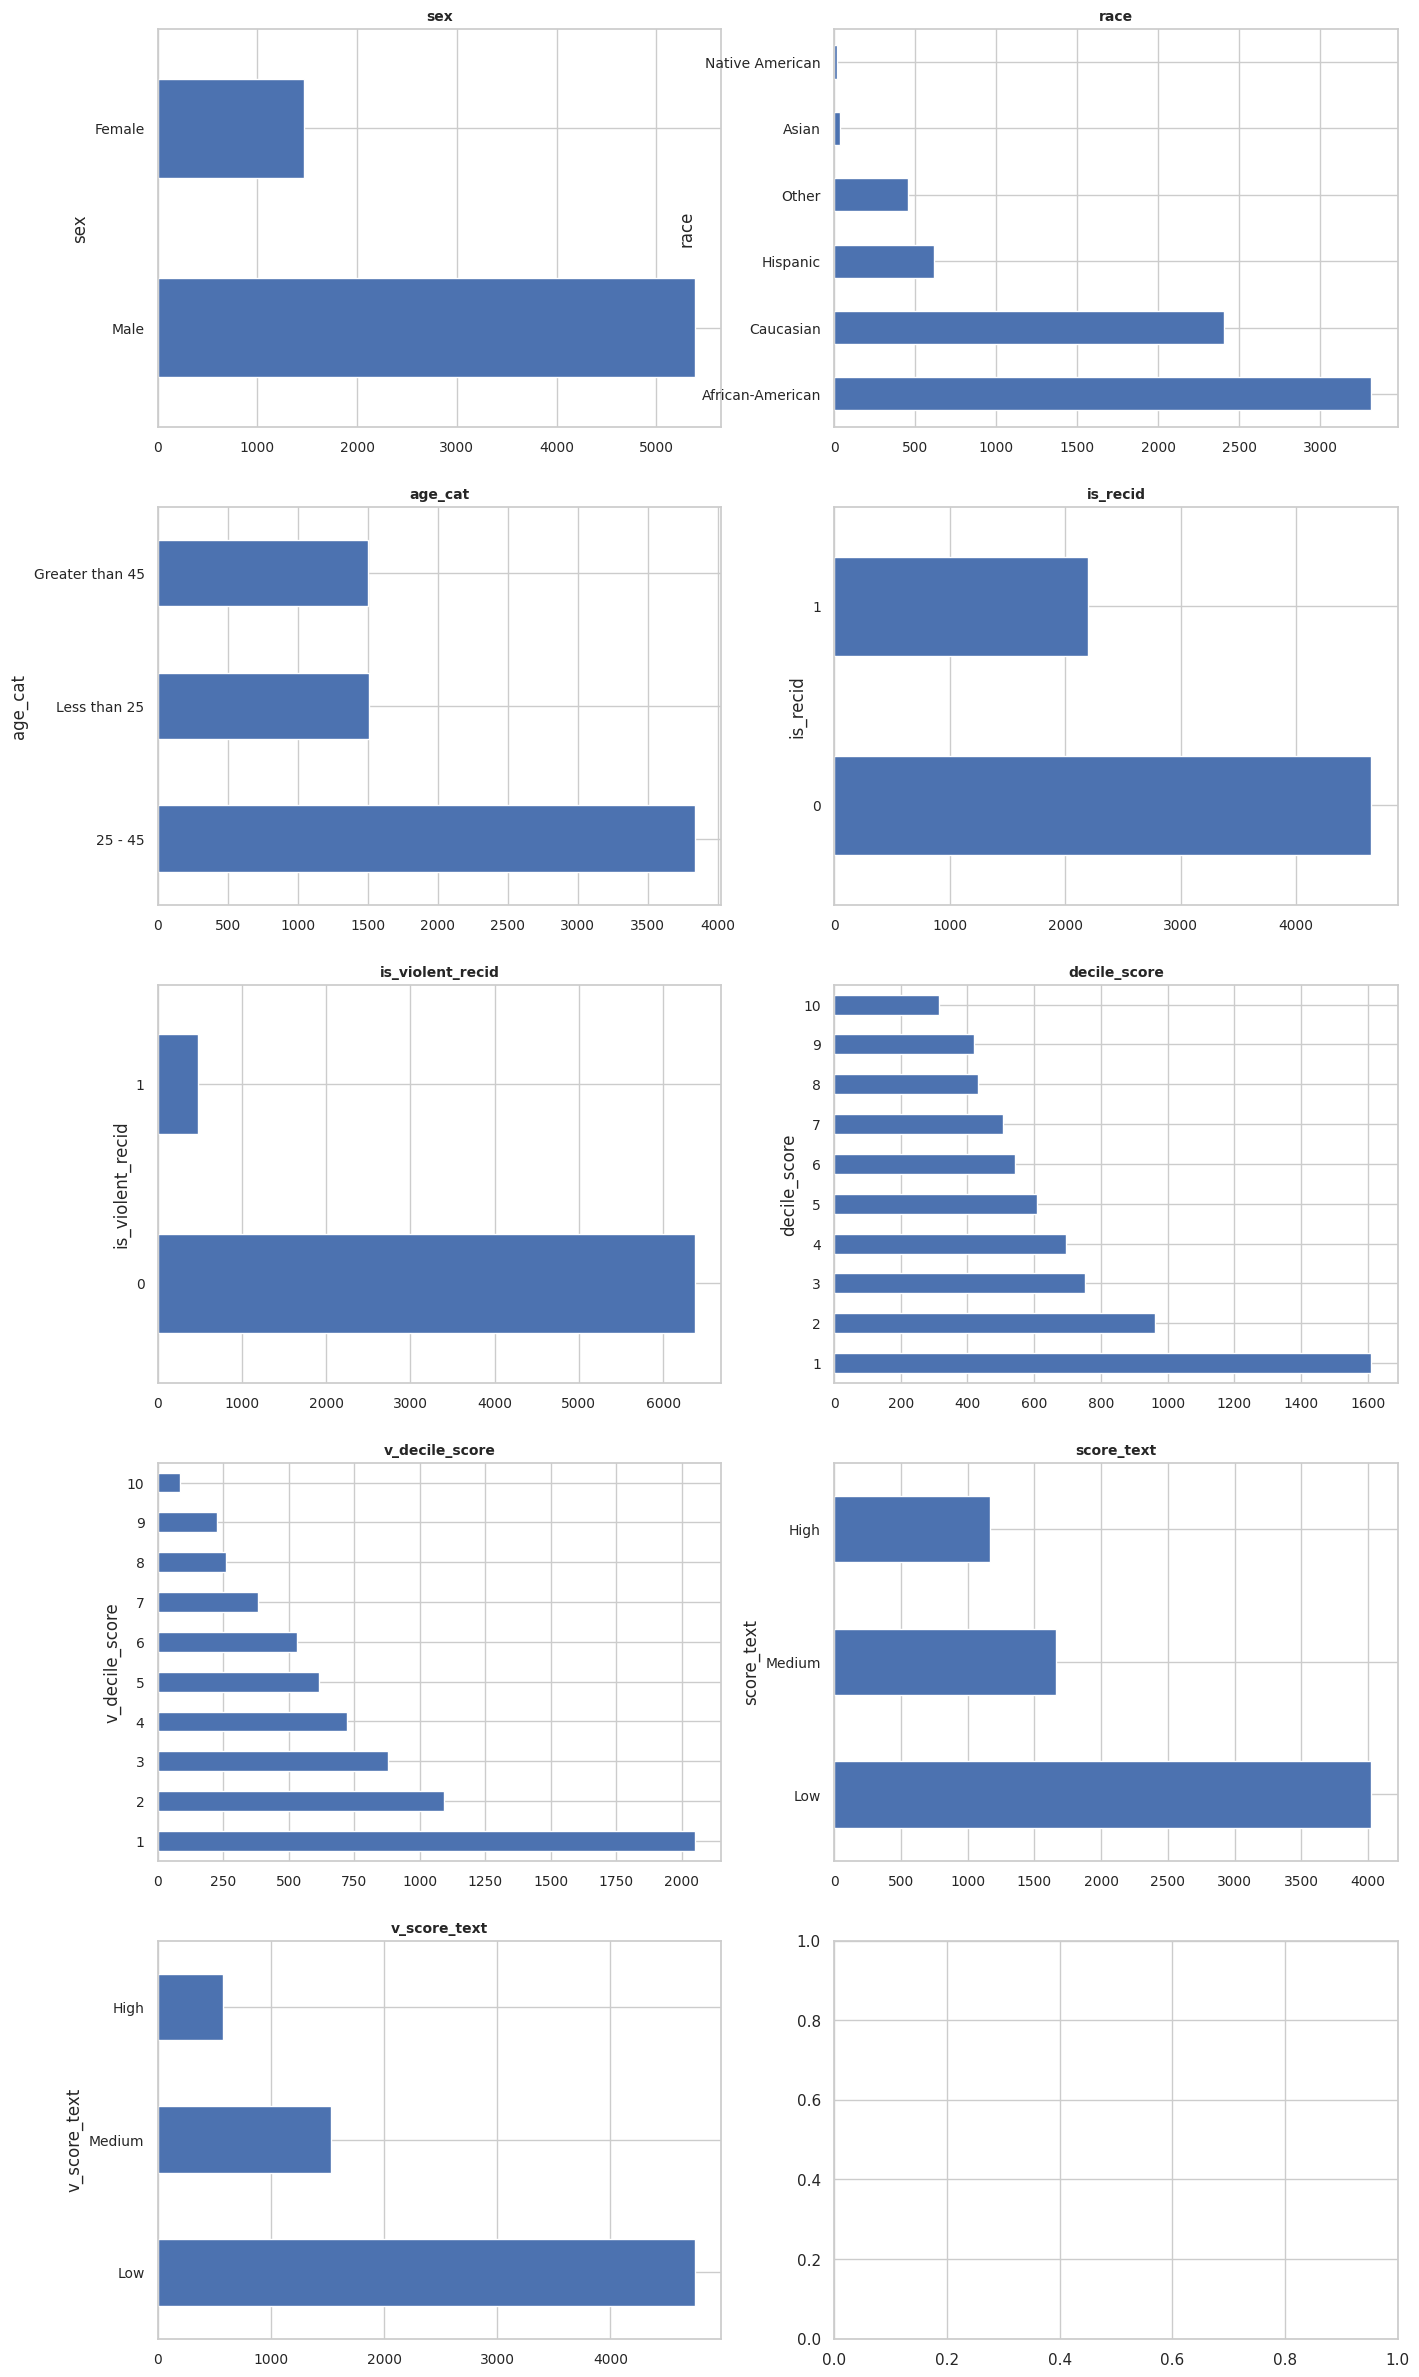

In [253]:
graficos_eda_categoricos(df.select_dtypes('category'))

Realizando un primer análisis en función de los datos arrojados por las gráficas podemos observar que:
* Hay mayor cantidad de registros de hombres que de mujeres
* Hay mayor cantidad de registros de personas Afro-Americanas
* Hay mayor cantidad de registros de personas entre 25 y 45 años
* Hay mayor cantidad de registros de personas no reincidentes que de personas reincidentes
* Hay menos de mil registros de personas con reincidencia por delitos con violencia.
* Para los campos "score" y "v_score" predominan en mayor cantidad aquellos registros con valoración "low"
* Como consecuencia de lo anterior, para los campos "decile_score" y "v_decile_core" predomina el valor "1".


*Este proceso podría ser tan iterativo como sea necesario, buscando investigar en mayor profundidad sobre los datos observados.*

In [254]:
# Análisis gráfico de variables tipo fecha

def graficos_eda_fechas(df, date_cols):

    # Calcular el número de filas necesarias
    filas = ceil(len(date_cols) / 3)

    # Definir el tamaño del gráfico
    f, ax = plt.subplots(nrows=filas, ncols=3, figsize=(18, filas * 6))

    # Aplanar el array de ejes para iterar fácilmente
    ax = ax.flat

    # Crear los gráficos
    for i, col in enumerate(date_cols):
        sns.histplot(df, x=col, color='red', kde=True, ax=ax[i])
        ax[i].set_title(col, fontsize=10, fontweight="bold")
        ax[i].tick_params(labelsize=10)
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

    # Ajustar el layout para que no se sobrepongan los gráficos
    plt.tight_layout()
    plt.show()

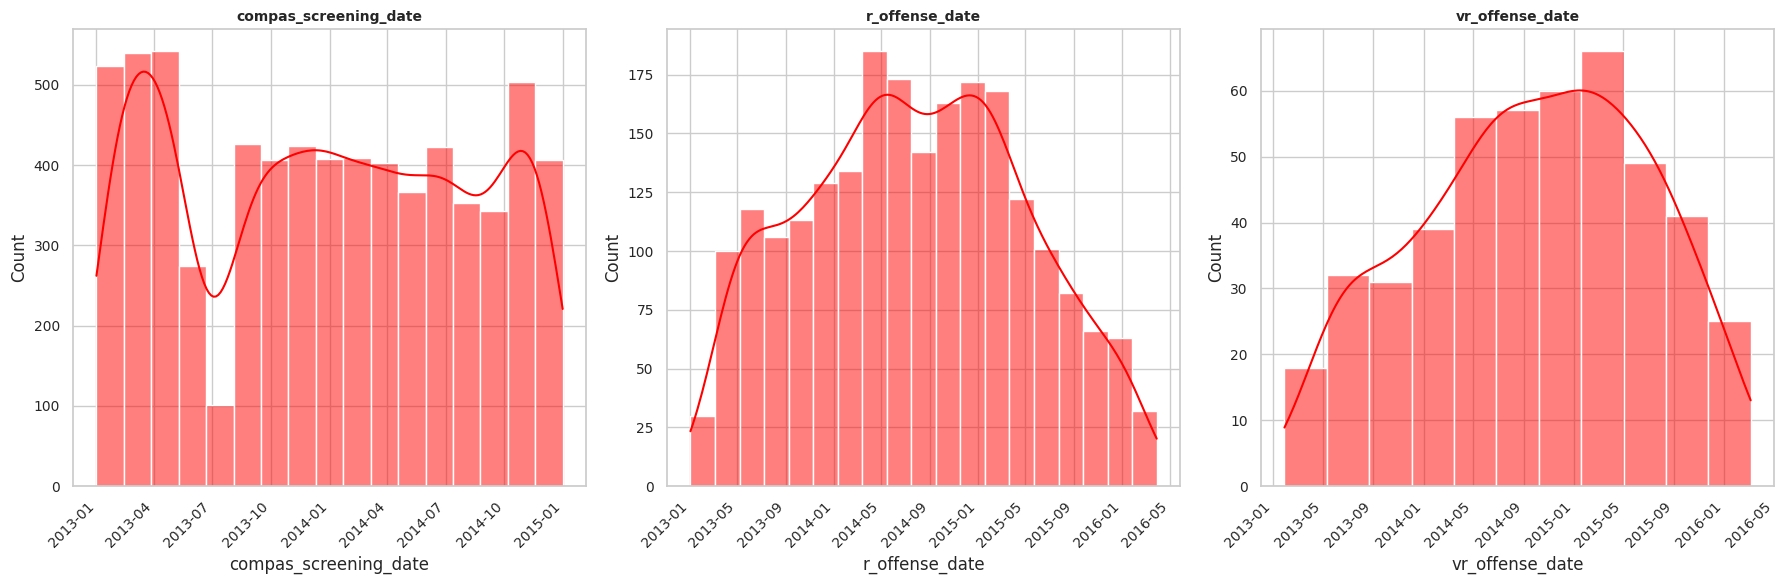

In [255]:
date_cols = ["compas_screening_date","r_offense_date","vr_offense_date"]
graficos_eda_fechas(df, date_cols)


Realizando un primer análisis en función de los datos arrojados por las gráficas podemos observar que:

* **r_offense_date** toma un periodo comprendido entre 2013 y 2016 (3 años)
* **vr_offense_date** toma un periodo comprendido entre 2013 y 2016 (3 años)
* **compass_screening_date** toma un periodo entre 2013 y 2015 (2 años)

Por lo tanto tenemos que tener en cuenta todos aquellas casuisticas comprendidas en el periodo de **compass_screening_date (2 años, entre 2013-2015)**

##2 - ¿Son los campos **“is_recid”** e **“is_violent_recid”** en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS? Si no es así, definir y calcular una feature que sí lo sea.

Las estimaciones de riesgo generadas por el sistema COMPAS se miden por las puntuaciones de los siguientes campos:

* **“decile_score”**: es un número, de 1 a 10 que indica el riesgo de reincidencia en general (a mayor riesgo, mayor número).    
* **“v_decile_score”**: es un número de 1 a 10, potencialmente distinto del anterior, que indica el riesgo de reincidencia en delitos violentos.

Al hacer la evaluación de un caso en COMPAS, se generan las dos puntuaciones (entre otras cosas).

Para evaluar si los campos **"is_recid" e "is_violent_recid"** son adecuados para evaluar la precisión de las estimaciones de riesgo de COMPAS, necesitamos examinar sus definiciones y contexto en relación con las puntuaciones de riesgo.

Definición y Uso:

**is_recid:** Indica si el individuo reincidió dentro del período de estudio (0 para no, 1 para sí).

**is_violent_recid:** Indica si el individuo reincidió con un delito violento dentro del período de estudio (0 para no, 1 para sí).


A priori, estos campos **"is_recid"** y **"is_violent_recid"** por si solos no son adecuados para estimar dichas evaluaciones.

No obstante, siempre se deben contrastar todas aquellas "estimaciones" y "asunciones" que se puedan hacer, por mas experiencia en la materia y conocimiento que se tenga sobre los datos.

Primero se determinará la correlación que existe entre las variables "is_recide" con "decile_score" y "is_violent_recide" con "v_decile_score".
Para ello utilizará el método: Correlación de Punto Biserial (correlación entre variable numerica y categorica)

In [256]:
# Transformación de columnas categoricas a numéricas
def cols_to_numeric (df, cols):
  for col in cols:
    df[col] = df[col].astype('int')

# Listas de columnas
cols_category = ['decile_score','v_decile_score']

# Aplicación de funciones
cols_to_numeric(df, cols_category)

# Confirmación de modificación
df.dtypes

id                                int64
name                             object
sex                            category
race                           category
dob                      datetime64[ns]
age                               int64
age_cat                        category
compas_screening_date    datetime64[ns]
is_recid                       category
is_violent_recid               category
decile_score                      int64
v_decile_score                    int64
vr_offense_date          datetime64[ns]
r_offense_date           datetime64[ns]
score_text                     category
v_score_text                   category
priors_count                      int64
dtype: object

In [257]:
from scipy.stats import pointbiserialr

# Variable categorica binaria: 'is_recid', "is_vionelt_recid" (0, 1)
# Variable numerica: 'decile_score', 'v_decile_score', 'priors_count' (valores numéricos)

def point_biserial_correlation(df, binary_cols, numeric_cols):
    for binary_col in binary_cols:
        for numeric_col in numeric_cols:
            # Calcular la correlación de punto biserial
            r, p_value = pointbiserialr(df[binary_col], df[numeric_col])

            print(f'Correlación de punto biserial entre {binary_col} y {numeric_col}:')
            print(f'Coeficiente de correlación: {r:.4f}')
            print(f'Valor p: {p_value:.4f}')
            print('---')

binary_cols = ['is_recid', 'is_violent_recid']
numeric_cols = ['decile_score', 'v_decile_score', 'priors_count']

point_biserial_correlation(df, binary_cols, numeric_cols)

Correlación de punto biserial entre is_recid y decile_score:
Coeficiente de correlación: 0.2917
Valor p: 0.0000
---
Correlación de punto biserial entre is_recid y v_decile_score:
Coeficiente de correlación: 0.2540
Valor p: 0.0000
---
Correlación de punto biserial entre is_recid y priors_count:
Coeficiente de correlación: 0.2570
Valor p: 0.0000
---
Correlación de punto biserial entre is_violent_recid y decile_score:
Coeficiente de correlación: 0.1524
Valor p: 0.0000
---
Correlación de punto biserial entre is_violent_recid y v_decile_score:
Coeficiente de correlación: 0.1512
Valor p: 0.0000
---
Correlación de punto biserial entre is_violent_recid y priors_count:
Coeficiente de correlación: 0.0920
Valor p: 0.0000
---


Coeficiente de correlación de punto biserial (r):

Este valor oscila entre -1 y 1. Un valor positivo indica que a medida que la variable categórica binaria aumenta (de 0 a 1), la variable numérica también tiende a aumentar. Un valor negativo indica lo contrario.

Valor p: Este valor indica si la correlación observada es significativa. Si
p<0.05, la correlación es significativa.
* p < 0.05: La correlación es estadísticamente significativa (hay menos del 5% de probabilidad de que la correlación observada se deba al azar).
* p ≥ 0.05: No hay suficiente evidencia para rechazar la hipótesis nula (la correlación observada puede deberse al azar).

De los resultados obtenidos, se podria decir que si bien el coeficiente de correlación de punto biseral es positivo para las variables en cuestión, este valor no es muy elevado. No obstante, el valor de p nos sugiere que la correlación es significativa.

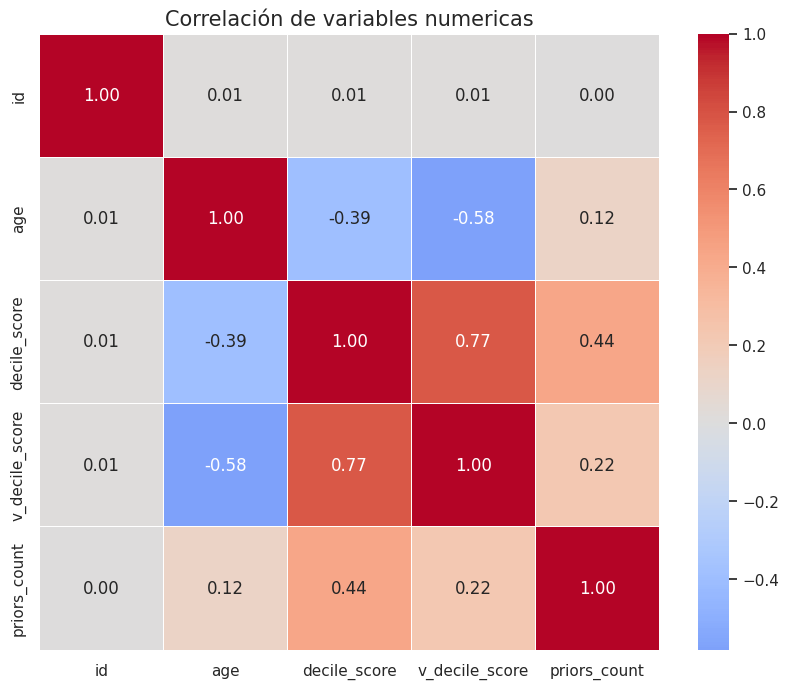

In [258]:
# Observación de correlación de variables numéricas
correlation = df.corr(numeric_only=True)

# Crear el gráfico de correlación
f, ax = plt.subplots(figsize=(10, 8))
plt.title('Correlación de variables numericas', size=15)

# Configurar el heatmap
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=.5, ax=ax)

plt.show()

Se definirán nuevas features teniendo en cuenta "priors_count" a las cuales las llamaremos "prior_recid" y "prior_vrecid".

In [259]:
# Definición de las nuevas features
df['prior_recid'] = np.where(
    (df['is_recid'] == 1) & (df['priors_count'] != 0),
    1, 0
)

df['prior_vrecid'] = np.where(
    (df['is_violent_recid'] == 1) & (df['priors_count'] != 0),
    1, 0
)
# Verificación de los valores de las nuevas features
print("prior_recid: valores únicos y sus conteos")
print(df['prior_recid'].value_counts())
print()

print("prior_vrecid: valores únicos y sus conteos")
print(df['prior_vrecid'].value_counts())
print()

prior_recid: valores únicos y sus conteos
prior_recid
0    5171
1    1676
Name: count, dtype: int64

prior_vrecid: valores únicos y sus conteos
prior_vrecid
0    6492
1     355
Name: count, dtype: int64



##3 - El umbral para establecer medidas preventivas de la reincidencia es de 7 en adelante. Dado este umbral, generar una tabla de contingencia, explicando qué caso se considera como “positivo” (y, por lo tanto, cuáles son los errores de tipo I y los errores de tipo II).

Para crear una tabla de contingencia basada en el umbral para medidas preventivas, necesitamos definir qué constituye un caso "positivo".

**Definiciones:**

**Casos Positivos:**
* Verdadero Positivo (TP): La predicción es positiva (decile_score >= 7) y la persona realmente reincidió (is_recid == 1).
* Verdadero Negativo (TN): La predicción es negativa (decile_score < 7) y la persona no reincidió (is_recid == 0).

**Error de Tipo I (Falso Positivo):**
* Falso Positivo (FP): La predicción es positiva (decile_score >= 7) pero la persona no reincidió (is_recid == 0).

**Error de Tipo II (Falso Negativo):**
* Falso Negativo (FN): La predicción es negativa (decile_score < 7) pero la persona realmente reincidió (is_recid == 1).


In [260]:
# Tabla de contingencia para 'is_recid'
c_table_r = pd.crosstab(df.is_recid==1, df.decile_score>=7, rownames=['| Prediccion |'], colnames=['| Actual |'])
c_table_r = c_table_r.rename(index={False: 'P.Negative', True: 'P.Positive'},columns={0: 'A.Negative', 1: 'A.Positive'})
c_table_r

| Actual |,A.Negative,A.Positive
| Prediccion |,,
P.Negative,3827,821
P.Positive,1346,853


In [261]:
TP = c_table_r.iloc[1,1]
TN = c_table_r.iloc[0,0]
FP = c_table_r.iloc[1,0]
FN = c_table_r.iloc[0,1]
TP, TN, FP, FN

(853, 3827, 1346, 821)

TP: P.Positive + A.Positive = 853

TN: P.Negative + A.Negative = 3827

FP(Error Tipo I): P.Positive + A.Negative = 1346

FN(Error Tipo II): P.Negative + A.Positive = 821

**Definiciones:**

**Casos Positivos:**
* Verdadero Positivo (TP): La predicción es positiva (v_decile_score >= 7) y la persona realmente reincidió (is_violent_recid == 1).
* Verdadero Negativo (TN): La predicción es negativa (v_decile_score < 7) y la persona no reincidió (is_violent_recid == 0).

**Error de Tipo I (Falso Positivo):**
* Falso Positivo (FP): La predicción es positiva (v_decile_score >= 7) pero la persona no reincidió (is_violent_recid == 0).

**Error de Tipo II (Falso Negativo):**
* Falso Negativo (FN): La predicción es negativa (v_decile_score < 7) pero la persona realmente reincidió (is_violent_recid == 1).

In [262]:
# Tabla de contingencia para 'is_violent_recid'
c_table_vr = pd.crosstab(df.v_decile_score>=7, df.is_violent_recid==1, rownames=['| Prediccion |'], colnames=['| Actual |'])
c_table_vr = c_table_vr.rename(index={False: 'P.Negative', True: 'P.Positive'},columns={0: 'A.Negative', 1: 'A.Positive'})
c_table_vr

| Actual |,A.Negative,A.Positive
| Prediccion |,,
P.Negative,5557,334
P.Positive,816,140


In [263]:
TP = c_table_vr.iloc[1,1]
TN = c_table_vr.iloc[0,0]
FP = c_table_vr.iloc[1,0]
FN = c_table_vr.iloc[0,1]
TP, TN, FP, FN

(140, 5557, 816, 334)

TP: P.Positive + A.Positive = 140

TN: P.Negative + A.Negative = 5557

FP(Error Tipo I): P.Positive + A.Negative = 816

FN(Error Tipo II): P.Negative + A.Positive = 334

**Definiciones:**

**Casos Positivos:**
* Verdadero Positivo (TP): La predicción es positiva (decile_score >= 7) y la persona realmente reincidió y tiene antecedentes de arrestos (prior_recid == 1).
* Verdadero Negativo (TN): La predicción es negativa (decile_score < 7) y la persona no reincidió ni tiene antecedentes de arrestos (prior_recid == 0).

**Error de Tipo I (Falso Positivo):**
* Falso Positivo (FP): La predicción es positiva (decile_score >= 7) pero la persona no reincidió ni tiene antecedentes de arrestos (prior_recid == 0).

**Error de Tipo II (Falso Negativo):**
* Falso Negativo (FN): La predicción es negativa (decile_score < 7) pero la persona realmente reincidió y tiene antecedentes de arrestos (prior_recid == 1).

In [264]:
# Tabla de contingencia para 'prior_recid'
c_table_pr = pd.crosstab(df.decile_score>=7, df.prior_recid==1, rownames=['| Prediccion |'], colnames=['| Actual |'])
c_table_pr = c_table_pr.rename(index={False: 'P.Negative', True: 'P.Positive'},columns={0: 'A.Negative', 1: 'A.Positive'})
c_table_pr

| Actual |,A.Negative,A.Positive
| Prediccion |,,
P.Negative,4225,948
P.Positive,946,728


In [265]:
TP = c_table_pr.iloc[1,1]
TN = c_table_pr.iloc[0,0]
FP = c_table_pr.iloc[1,0]
FN = c_table_pr.iloc[0,1]
TP, TN, FP, FN

(728, 4225, 946, 948)

TP: P.Positive + A.Positive = 728

TN: P.Negative + A.Negative = 4425

FP(Error Tipo I): P.Positive + A.Negative = 946

FN(Error Tipo II): P.Negative + A.Positive = 948

**Definiciones:**

**Casos Positivos:**

* Verdadero Positivo (TP): La predicción es positiva (v_decile_score >= 7) y la persona realmente reincidió y tiene antecedentes de arrestos violentos (prior_vrecid == 1).
* Verdadero Negativo (TN): La predicción es negativa (v_decile_score < 7) y la persona no reincidió ni tiene antecedentes de arrestos violentos (prior_vrecid == 0).

**Error de Tipo I (Falso Positivo):**

* Falso Positivo (FP): La predicción es positiva (v_decile_score >= 7) pero la persona no reincidió ni tiene antecedentes de arrestos violentos (prior_vrecid == 0).

**Error de Tipo II (Falso Negativo):**

* Falso Negativo (FN): La predicción es negativa (v_decile_score < 7) pero la persona realmente reincidió y tiene antecedentes de arrestos violentos (prior_vrecid == 1).

In [266]:
# Tabla de contingencia para 'prior_vrecid'
c_table_pvr = pd.crosstab(df.v_decile_score>=7, df.prior_vrecid==1, rownames=['| Prediccion |'], colnames=['| Actual |'])
c_table_pvr = c_table_pvr.rename(index={False: 'P.Negative', True: 'P.Positive'},columns={0: 'A.Negative', 1: 'A.Positive'})
c_table_pvr

| Actual |,A.Negative,A.Positive
| Prediccion |,,
P.Negative,5642,249
P.Positive,850,106


In [267]:
TP = c_table_pvr.iloc[1,1]
TN = c_table_pvr.iloc[0,0]
FP = c_table_pvr.iloc[1,0]
FN = c_table_pvr.iloc[0,1]
TP, TN, FP, FN

(106, 5642, 850, 249)

**Métricas de performance**

In [268]:
# Función para calcular las métricas de performance
def calculate_metrics(contingency_table):
    TP = contingency_table.loc['P.Positive', 'A.Positive']
    FP = contingency_table.loc['P.Positive', 'A.Negative']
    TN = contingency_table.loc['P.Negative', 'A.Negative']
    FN = contingency_table.loc['P.Negative', 'A.Positive']

    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1}")

# Calculo de metricas para las tablas de contingencias

print("Métricas para delitos generales")
metrics_c_table_r = calculate_metrics(c_table_r)
metrics_c_table_pr = calculate_metrics(c_table_pr)
print()
print("Métricas para delitos violentos")
metrics_c_table_vr = calculate_metrics(c_table_vr)
metrics_c_table_pvr = calculate_metrics(c_table_pvr)

Métricas para delitos generales
accuracy: 0.6835110267270338, precision: 0.3879035925420646, recall: 0.5095579450418161, f1: 0.44048541182545836
accuracy: 0.7233825032861108, precision: 0.4348864994026284, recall: 0.4343675417661098, f1: 0.4346268656716418

Métricas para delitos violentos
accuracy: 0.8320432306119468, precision: 0.14644351464435146, recall: 0.29535864978902954, f1: 0.1958041958041958
accuracy: 0.8394917482108952, precision: 0.1108786610878661, recall: 0.29859154929577464, f1: 0.16170861937452327


**Interpretación**

Valores más altos de exactitud, precisión, recall y F1-score indican una mejor capacidad predictiva.


##4 - El sistema asigna, de media, evaluaciones de riesgo más altas a los hombres que a las mujeres, y a las personas de raza afroamericana que a las de raza caucásica. Sin embargo, también las tasas de reincidencia son más altas para esos colectivos, aunque no está claro que la asignación de riesgo sea “justa” o no. Mostrar estas diferencias mediante representaciones gráficas y utilizarlas para analizar si la asignación de evaluaciones es justa o no.

* Se utilizará gráficos de barras para comparar las tasas reales de reincidencia general y violenta por género y raza.


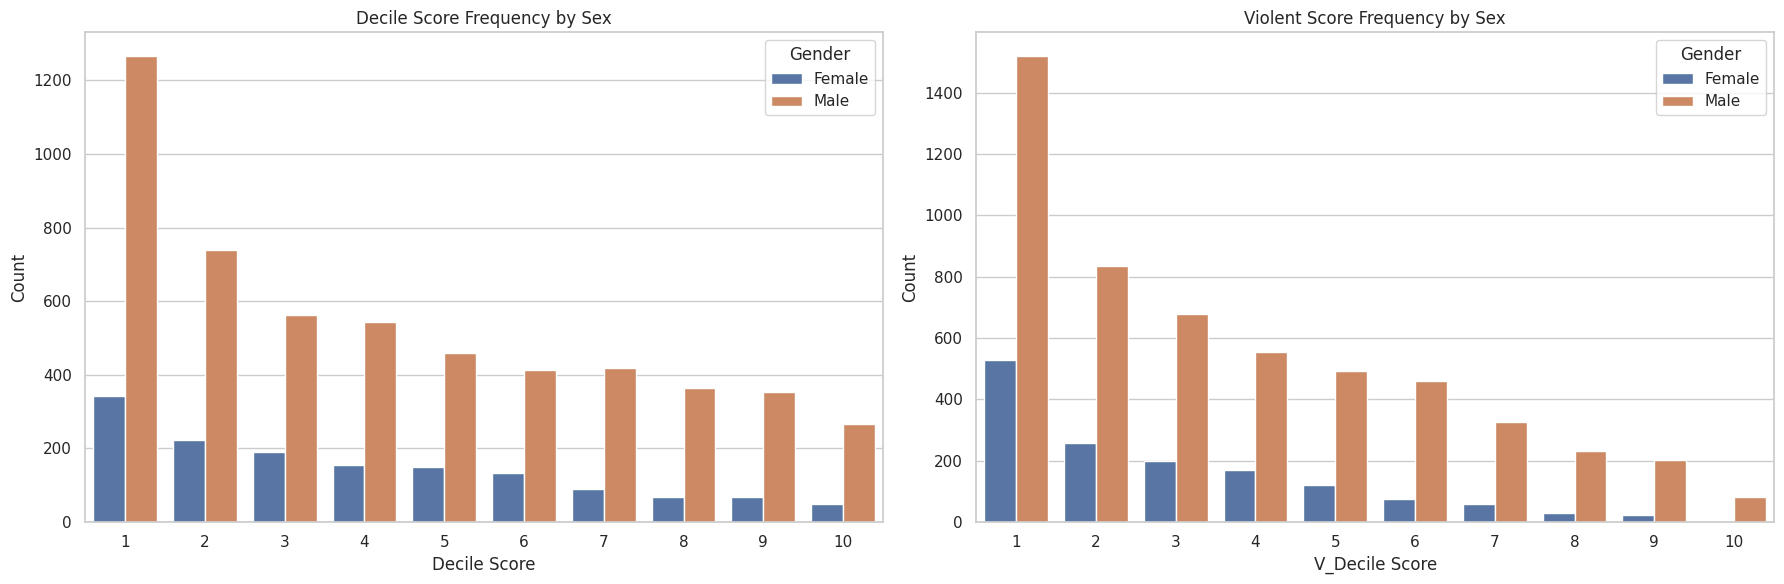

In [269]:
# Gráficos para género.
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot para 'decile_score' y 'sex'
sns.countplot(x='decile_score', hue='sex', data=df, palette='deep', ax=axes[0])
axes[0].set_xlabel('Decile Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Decile Score Frequency by Sex')
axes[0].legend(title='Gender')

# Bar plot para 'v_decile_score' y 'sex'
sns.countplot(x='v_decile_score', hue='sex', data=df, palette='deep', ax=axes[1])
axes[1].set_xlabel('V_Decile Score')
axes[1].set_ylabel('Count')
axes[1].set_title('Violent Score Frequency by Sex')
axes[1].legend(title='Gender')

plt.tight_layout()
plt.show()

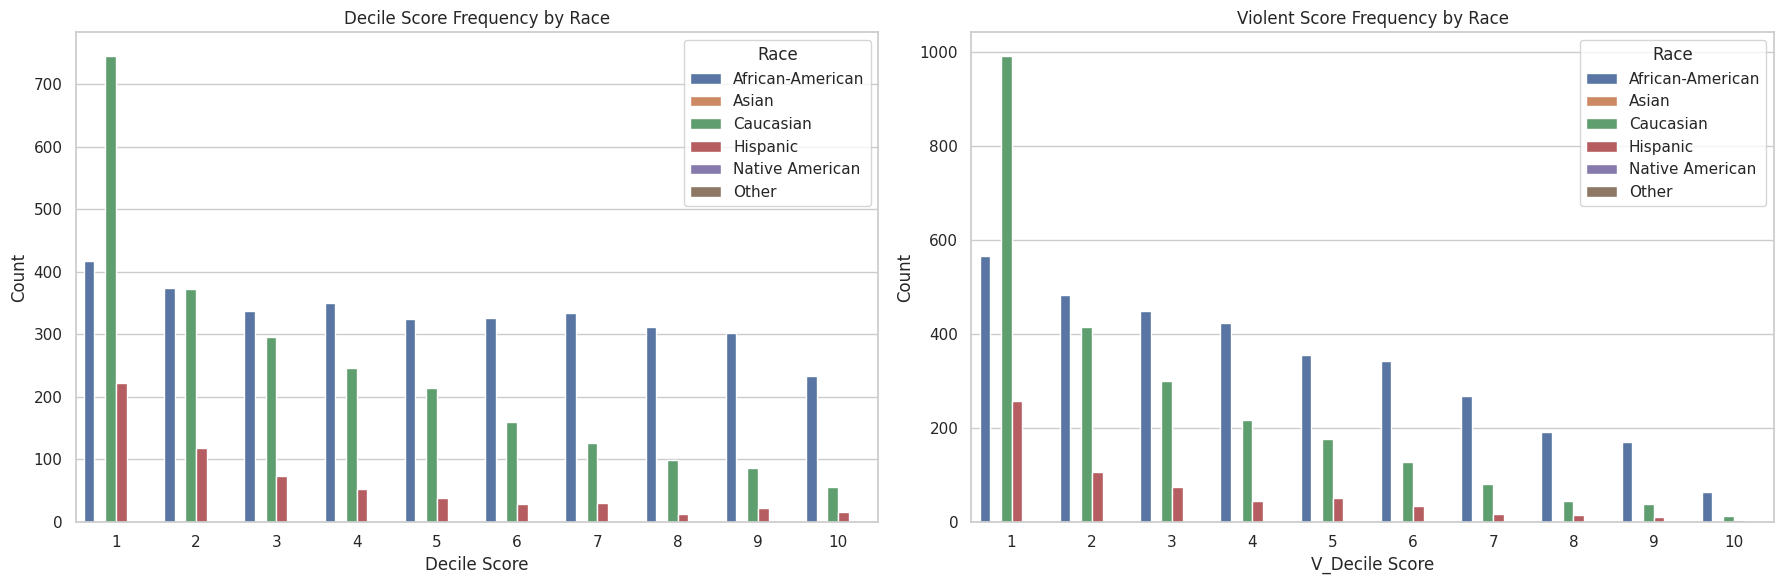

In [270]:
# Gráficos para raza
sns.set(style="whitegrid")

# Razas seleccionadas 'African-American', 'Caucasian' y 'Hispanic'.
selected_races = ['African-American', 'Caucasian', 'Hispanic']
df_filtered = df[df['race'].isin(selected_races)]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot para 'decile_score' y 'races'
sns.countplot(x='decile_score', hue='race', data=df_filtered, palette='deep', ax=axes[0])
axes[0].set_xlabel('Decile Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Decile Score Frequency by Race')
axes[0].legend(title='Race')

# Bar plot para 'v_decile_score' y 'races'
sns.countplot(x='v_decile_score', hue='race', data=df_filtered, palette='deep', ax=axes[1])
axes[1].set_xlabel('V_Decile Score')
axes[1].set_ylabel('Count')
axes[1].set_title('Violent Score Frequency by Race')
axes[1].legend(title='Race')

plt.tight_layout()
plt.show()

**Evaluación de la Equidad**

Para evaluar la equidad, se compara las distribuciones de las puntuaciones de riesgo y las tasas reales de reincidencia:

* Con respecto a la distribución de frecuencia por genero, se observan unas mejores valoraciones en general para las mujeres. Esta tendencia es más evidente en los niveles altos de la escala de riesgo, sobre todo en reincidencia por delitos con violencia.

* Con respecto a la distribución de frecuencia por raza, se observan más casos de  afroamericanos con peores evaluaciones (más riesgo a reincidencia). Superan en mayor cantidad el umbral de 7 con respecto a otras razas. Un detalle no menor es que la cantidad de personas de raza Afro-Americana es mayor, por lo tanto no se realiza una comparación equitativa.

In [235]:
df['sex'].value_counts()

sex
Male      5383
Female    1464
Name: count, dtype: int64

In [236]:
df['race'].value_counts()

race
African-American    3312
Caucasian           2405
Hispanic             616
Other                457
Asian                 39
Native American       18
Name: count, dtype: int64

## 5 - ¿Para qué tipo de riesgos, el de delitos generales o el de delitos violentos, tiene el sistema más capacidad predictiva?

En función de las métricas desarrolladas en el **punto 3** y comparando el valor para ambos casos de "accuracy" o exactitud, de forma rápida y sin mayor desarrollo para corroborar esta afirmación, se puede decir que el sistema tiene mayor capacidad de predicción para delitos violentos, siendo **0.83** el valor para delitos violentos y **0.68** para delitos no violentos

